In [64]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talib
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 具体路径根据系统字体路径设置
font_prop = fm.FontProperties(fname=font_path)

# 此函数适用范围有限，还有待改进
def get_full_ticker(stock_code):
    """
    根据输入的6位代码，判断是深交所还是上交所的股票，并返回完整的股票代码。
    
    参数:
    stock_code (str): 6位股票代码
    
    返回:
    str: 完整的股票代码（包括交易所后缀）
    """
    if not isinstance(stock_code, str) or len(stock_code) != 6 or not stock_code.isdigit():
        raise ValueError("股票代码必须是6位数字字符串")

    if stock_code.startswith('6'):
        return stock_code + '.SS'
    elif stock_code.startswith('0'):
        return stock_code + '.SZ'
    else:
        raise ValueError("无效的股票代码")

# 使用xlsx 效率太低，后续需要改成sqlite
def get_stock_name(ticker):
    """
    根据股票代码获取股票名称。
    
    参数:
    ticker (str): 股票代码
    
    返回:
    str: 股票名称
    """
    file = "A股上市公司清单-20240816.xlsx"
    xlsx = pd.ExcelFile(file)
    df = pd.read_excel(xlsx)
    df['股票代码'] = df['股票代码'].astype(str).str.split('.').str[0]
    result = df[df['股票代码'] == ticker]['证券名称']
    if not result.empty:
        return result.values[0]
    else:
        return f"未找到股票代码为{ticker}的公司"

def stock_analysis(ticker):

    # Step 1: Obtain the stock historical data (Yiling Pharmaceutical, 002603.SZ)
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=1 * 365)).strftime('%Y-%m-%d')
    
    stock_data = yf.download(get_full_ticker(ticker), start=start_date, end=end_date)
    
    # Step 2: Calculate short-term (20 days) and long-term (50 days) sliding averages and Bollinger Bands
    stock_data['SMA20'] = talib.SMA(stock_data['Close'], timeperiod=20)
    stock_data['SMA50'] = talib.SMA(stock_data['Close'], timeperiod=50)
    stock_data['UpperBand'], stock_data['MiddleBand'], stock_data['LowerBand'] = talib.BBANDS(stock_data['Close'],
                                                                                              timeperiod=20)
    
    # Step 3: Predict the trend data for the next 3 months
    X = np.array(range(len(stock_data))).reshape(-1, 1)
    y = stock_data['Close'].values
    
    # Linear Regression for trend prediction
    model = LinearRegression()
    model.fit(X, y)
    future_days = 90  # Predict for 3 months (approx. 90 days)
    future_X = np.array(range(len(stock_data) + future_days)).reshape(-1, 1)
    predicted_y = model.predict(future_X)
    
    # Step 4: Plotting the data with Bollinger Bands and teacup handle prediction
    plt.figure(figsize=(16, 8), dpi=300)
    
    # Plot historical data
    plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
    plt.plot(stock_data.index, stock_data['SMA20'], label='20-Day SMA', color='orange')
    plt.plot(stock_data.index, stock_data['SMA50'], label='50-Day SMA', color='green')
    plt.plot(stock_data.index, stock_data['UpperBand'], label='Upper Bollinger Band', color='red', linestyle='--')
    plt.plot(stock_data.index, stock_data['LowerBand'], label='Lower Bollinger Band', color='red', linestyle='--')
    
    # Plot predicted data
    future_dates = pd.date_range(stock_data.index[-1], periods=future_days + 1, inclusive='right')
    plt.plot(future_dates, predicted_y[-future_days:], label='Predicted Close Price', color='purple', linestyle='--')
    
    # Step 5: Add reference lines
    buy_price = stock_data['Close'].iloc[-1]
    stop_loss_price = buy_price * 0.8  # Stop loss at 20% below buying price
    
    plt.axhline(y=buy_price, color='cyan', linestyle='--', label=f'Buy Price: {buy_price:.2f}')
    plt.axhline(y=stop_loss_price, color='red', linestyle='--', label=f'Stop Loss Price: {stop_loss_price:.2f}')
    
    # Step 6: Mark today's price with a circle
    plt.scatter(stock_data.index[-1], stock_data['Close'].iloc[-1], color='black', label="Today's Price", zorder=5)
    
    # Formatting the plot
    stock_name = get_stock_name(ticker)
    plt.title(f'{stock_name} Stock Price with Bollinger Bands and Predictions', pad=20, fontproperties=font_prop)
    plt.xlabel('Date')
    plt.ylabel('Price (CNY)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.show()

[*********************100%%**********************]  1 of 1 completed


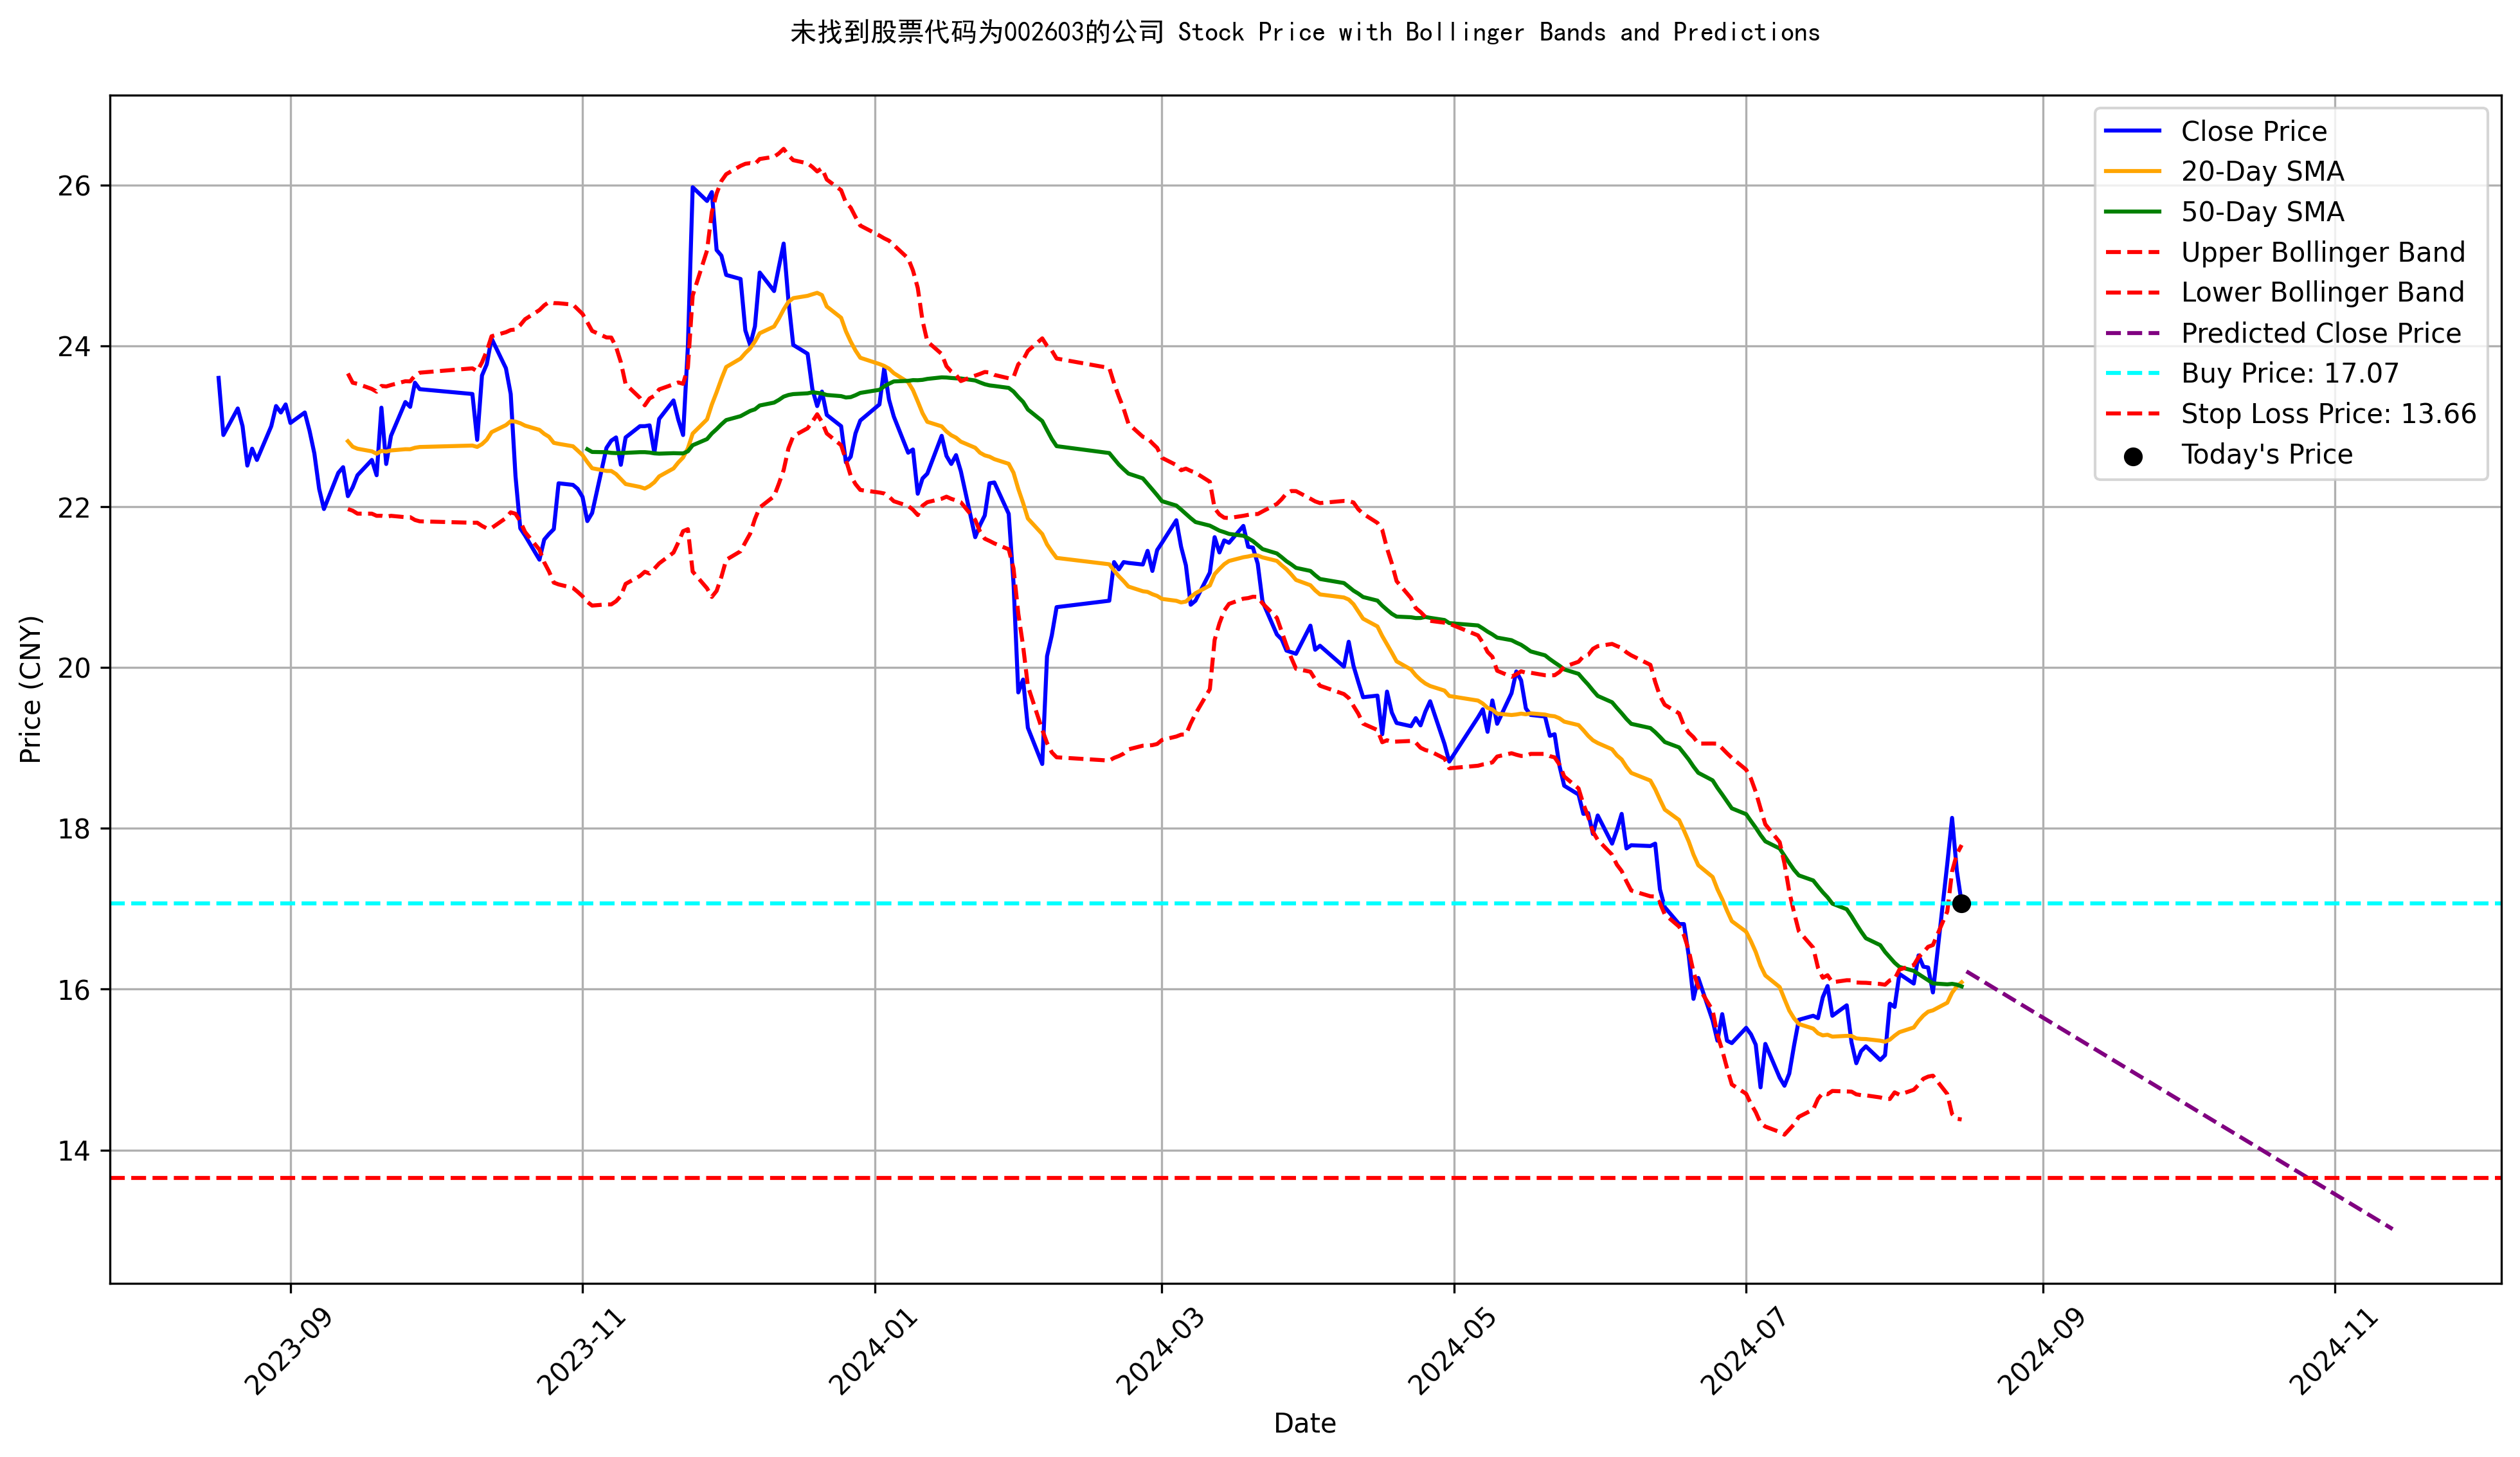

In [65]:
ticker = '002603' 
stock_analysis(ticker)

In [67]:
get_stock_name(ticker)
ticker

'002603'

In [68]:
file = "A股上市公司清单-20240816.xlsx"
xlsx = pd.ExcelFile(file)
df = pd.read_excel(xlsx)
df['股票代码'] = df['股票代码'].astype(str).str.split('.').str[0]
result = df[df['股票代码'] == ticker]['证券名称']
df

,证券代码,证券名称,英文简称,股票代码,首发上市日期,上市板块,上市交易所,上市状态\n[截止日期] 最新,摘牌日期,A股做市起始日期\n[截止日期] 最新,...,销售商品、提供劳务收到的现金\n[报告期] 2018年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2019年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2020年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2021年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2022年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2023年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2024年报\n[报表类型] 合并报表\n[单位] 元,区间开盘价\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[复权方式] 不复权\n[单位]元,区间收盘价\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[复权方式] 不复权\n[单位]元,区间换手率\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[单位]%
0,430017.BJ,星昊医药,--,430017,2023-05-31,北证,北交所,在市,--,--,...,382831720.48,659240055.36,577312962.46,588761072.34,573181455.77,760950154.02,--,11.00,11.33,741.9186
1,430047.BJ,诺思兰德,NORTHLAND,430047,2020-11-24,北证,北交所,在市,--,"20230220,20230914,20231214,20240129",...,12436361.5,7681415.92,40126932.92,59662329.62,95468119.36,70127546.43,--,6.20,12.10,743.8951
2,430090.BJ,同辉信息,--,430090,2021-08-09,北证,北交所,在市,--,--,...,598575280.41,658199190.28,396339746.9,675946977.86,392400506.63,247521365.53,--,2.97,2.87,2534.1842
3,430139.BJ,华岭股份,Sino IC,430139,2022-10-28,北证,北交所,在市,--,"20230220,20230726,20230914,20231020,20231213,2...",...,137852168.81,140954507.74,154113447.18,306231247.82,285313973.03,311284386.8,--,14.00,8.63,489.6424
4,430198.BJ,微创光电,WELLTRANS,430198,2020-07-27,北证,北交所,在市,--,"20230220,20230810",...,133798021.66,142504377.64,187896508.62,171579878.43,123258001.39,203500497.74,--,23.38,5.33,2007.3273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350,301603.SZ,乔锋智能,JIRFINE,301603,2024-07-10,创业板,深交所,在市,--,--,...,--,323045925.7,503083770.24,856264909.66,997377354,1084372916.7,--,58.88,38.42,914.4106
5351,301606.SZ,绿联科技,UGREEN,301606,2024-07-26,创业板,深交所,在市,--,--,...,--,2310096776.44,3041045942.63,3886576707.91,4258191935.83,5239123478.61,--,40.00,30.17,467.8675
5352,301608.SZ,博实结,BSJ,301608,2024-08-01,创业板,深交所,在市,--,--,...,--,854278165.98,1031246520.01,1316212000.53,1233051701.57,903635833.14,--,88.88,60.07,384.5658
5353,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
import sqlite3

# 连接到数据库（如果数据库不存在，则会自动创建）
conn = sqlite3.connect('stock_data.db')
cursor = conn.cursor()

# 创建表，添加中文注释
cursor.execute('''
CREATE TABLE IF NOT EXISTS stocks_lists (
    stock_code TEXT PRIMARY KEY, -- 股票代码
    company_name_cn TEXT, -- 公司中文名称
    company_name_en TEXT, -- 公司英文名称
    province TEXT, -- 省份
    listing_date DATE, -- 上市时间
    exchange TEXT, -- 证券交易所
    update_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP -- 更新时间
)
''')

# 提交更改并关闭连接
conn.commit()
conn.close()

In [79]:
conn = sqlite3.connect('stock_data.db')
cursor = conn.cursor()
ds = df[['证券代码', '公司中文名称', '公司英文名称', '省份', '首发上市日期', '上市交易所']]
ds.to_sql('stocks_lists', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

In [72]:
df['']

,证券代码,证券名称,英文简称,股票代码,首发上市日期,上市板块,上市交易所,上市状态\n[截止日期] 最新,摘牌日期,A股做市起始日期\n[截止日期] 最新,...,销售商品、提供劳务收到的现金\n[报告期] 2018年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2019年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2020年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2021年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2022年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2023年报\n[报表类型] 合并报表\n[单位] 元,销售商品、提供劳务收到的现金\n[报告期] 2024年报\n[报表类型] 合并报表\n[单位] 元,区间开盘价\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[复权方式] 不复权\n[单位]元,区间收盘价\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[复权方式] 不复权\n[单位]元,区间换手率\n[起始交易日期] 20000101\n[截止交易日期] 最新\n[单位]%
0,430017.BJ,星昊医药,--,430017,2023-05-31,北证,北交所,在市,--,--,...,382831720.48,659240055.36,577312962.46,588761072.34,573181455.77,760950154.02,--,11.00,11.33,741.9186
1,430047.BJ,诺思兰德,NORTHLAND,430047,2020-11-24,北证,北交所,在市,--,"20230220,20230914,20231214,20240129",...,12436361.5,7681415.92,40126932.92,59662329.62,95468119.36,70127546.43,--,6.20,12.10,743.8951
2,430090.BJ,同辉信息,--,430090,2021-08-09,北证,北交所,在市,--,--,...,598575280.41,658199190.28,396339746.9,675946977.86,392400506.63,247521365.53,--,2.97,2.87,2534.1842
3,430139.BJ,华岭股份,Sino IC,430139,2022-10-28,北证,北交所,在市,--,"20230220,20230726,20230914,20231020,20231213,2...",...,137852168.81,140954507.74,154113447.18,306231247.82,285313973.03,311284386.8,--,14.00,8.63,489.6424
4,430198.BJ,微创光电,WELLTRANS,430198,2020-07-27,北证,北交所,在市,--,"20230220,20230810",...,133798021.66,142504377.64,187896508.62,171579878.43,123258001.39,203500497.74,--,23.38,5.33,2007.3273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350,301603.SZ,乔锋智能,JIRFINE,301603,2024-07-10,创业板,深交所,在市,--,--,...,--,323045925.7,503083770.24,856264909.66,997377354,1084372916.7,--,58.88,38.42,914.4106
5351,301606.SZ,绿联科技,UGREEN,301606,2024-07-26,创业板,深交所,在市,--,--,...,--,2310096776.44,3041045942.63,3886576707.91,4258191935.83,5239123478.61,--,40.00,30.17,467.8675
5352,301608.SZ,博实结,BSJ,301608,2024-08-01,创业板,深交所,在市,--,--,...,--,854278165.98,1031246520.01,1316212000.53,1233051701.57,903635833.14,--,88.88,60.07,384.5658
5353,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talib
import sqlite3
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

In [5]:
ticker = '002603.SZ'
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=1 * 365)).strftime('%Y-%m-%d')

stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [40]:
# data preprocessing
stock_data.reset_index(inplace=True)
stock_data.insert(0, 'Stock_Code', ticker)
# 修整数据
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
    stock_data[col] = round(stock_data[col], 2)

# 将数据存入数据库
conn = sqlite3.connect('stock_data.db')
cusor = conn.cursor()
# 创建表
cusor.execute('''
CREATE TABLE IF NOT EXISTS stock_data (
    Code TEXT,
    Date TEXT PRIMARY KEY,
    Open REAL,
    High REAL,
    Low REAL,
    Close REAL,
    Adj Close REAL,
    Volume INTEGER
)
''')
stock_data.to_sql('stock_data', conn, if_exists='replace', index=False) # 表存咋
conn.commit()
conn.close()

In [3]:
# 检查今天是否已经更新数据
conn = sqlite3.connect('stock_data.db')
cusor = conn.cursor()
today = datetime.today().strftime('%Y-%m-%d')
cusor.execute(f'SELECT * FROM stock_data WHERE Date="{today}"')
data = cusor.fetchone()

if data:
    print(data)
else:
    print('No data for today')

No data for today


In [20]:
from gm.api import set_token
from datetime import datetime

# 初始化掘金API
set_token('32979144ea527c5772234045ed779125a37ff5be')

# 获取今天的日期
today = datetime.today().strftime('%Y-%m-%d')

# 获取历史数据
data = gm.history(symbol=ticker, start_time=today, end_time=today, frequency='1d')

In [21]:
data

[]

In [25]:
# Step 1:# 检查今天是否已经更新数据
conn = sqlite3.connect('stock_data.db')
cusor = conn.cursor()
query = f'SELECT * FROM stock_data'
stock_data = pd.read_sql(query, conn)
stock_data['Date'] = pd.to_datetime(stock_data['Date']) # 转换为日期格式
conn.close()

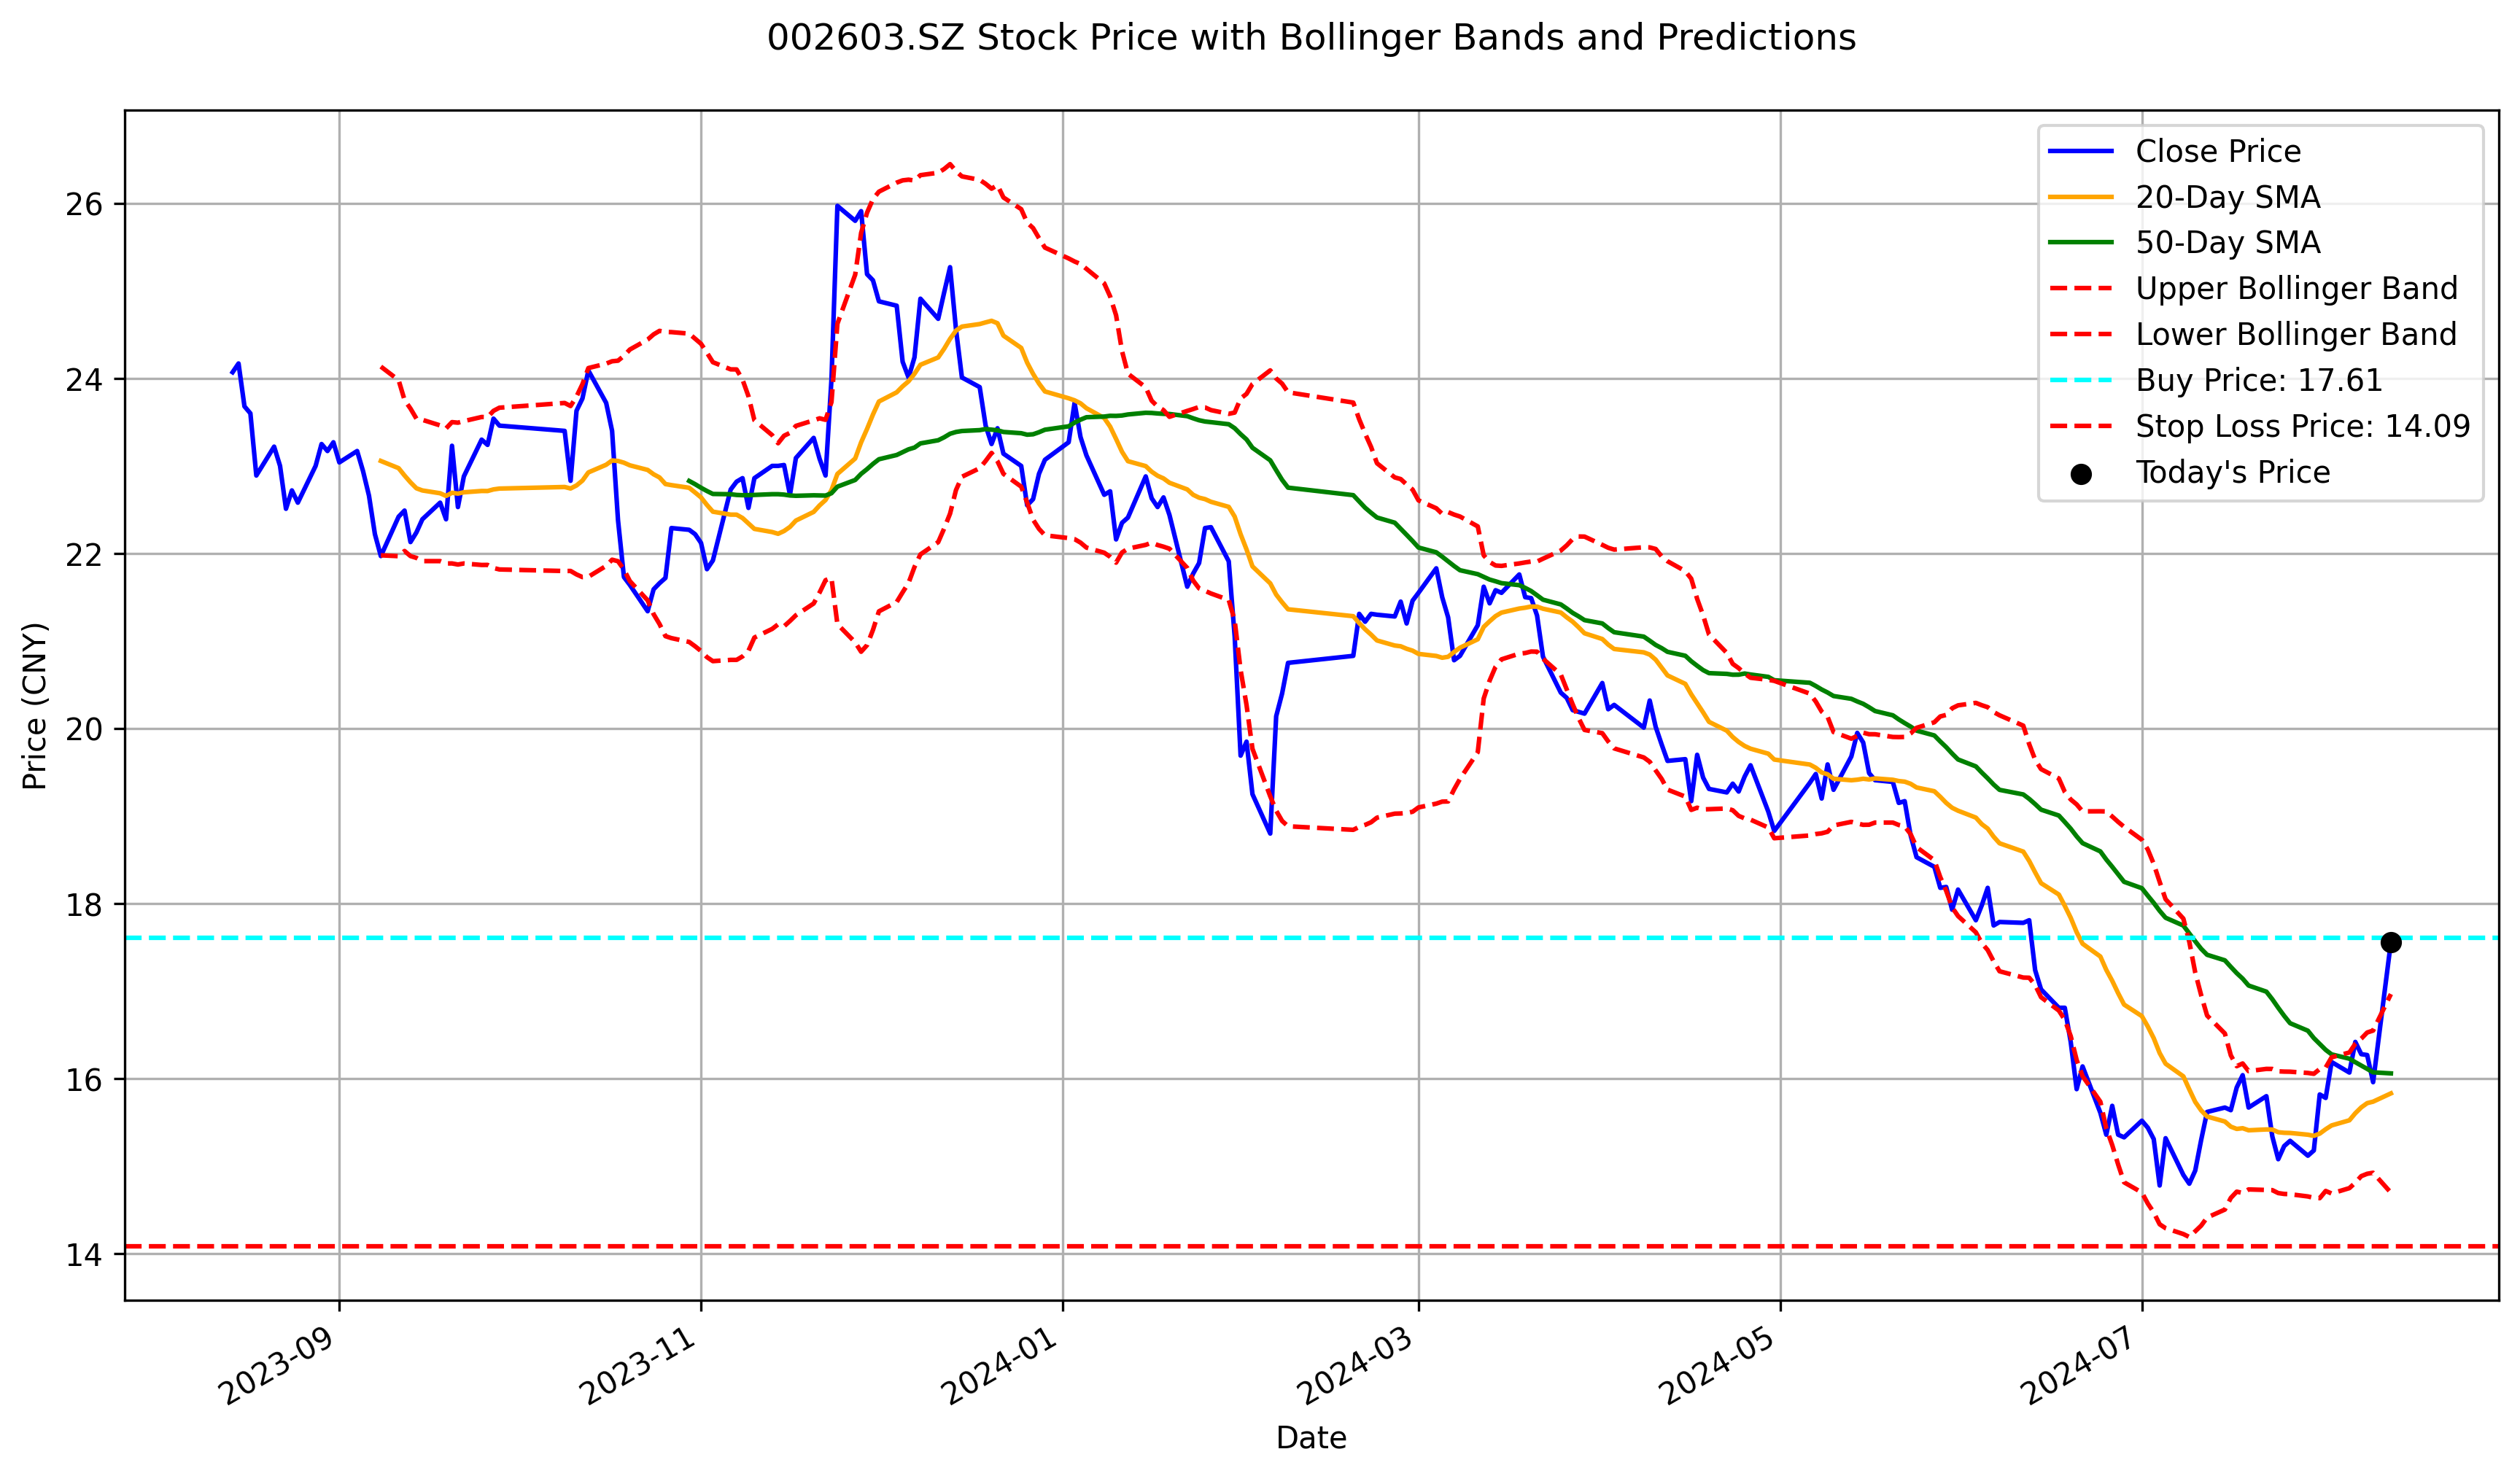

In [26]:
# Step 2: Calculate short-term (20 days) and long-term (50 days) sliding averages and Bollinger Bands
stock_data['SMA20'] = talib.SMA(stock_data['Close'], timeperiod=20)
stock_data['SMA50'] = talib.SMA(stock_data['Close'], timeperiod=50)
stock_data['UpperBand'], stock_data['MiddleBand'], stock_data['LowerBand'] = talib.BBANDS(stock_data['Close'],
                                                                                          timeperiod=20)

# Step 3: Predict the trend data for the next 3 months
X = np.array(range(len(stock_data))).reshape(-1, 1)
y = stock_data['Close'].values

# Linear Regression for trend prediction
model = LinearRegression()
model.fit(X, y)
future_days = 90  # Predict for 3 months (approx. 90 days)
future_X = np.array(range(len(stock_data) + future_days)).reshape(-1, 1)
predicted_y = model.predict(future_X)

# Step 4: Plotting the data with Bollinger Bands and teacup handle prediction
plt.figure(figsize=(14, 8), dpi=300)

# Plot historical data
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['Date'], stock_data['SMA20'], label='20-Day SMA', color='orange')
plt.plot(stock_data['Date'], stock_data['SMA50'], label='50-Day SMA', color='green')
# plot Bollinger Bands
plt.plot(stock_data['Date'], stock_data['UpperBand'], label='Upper Bollinger Band', color='red', linestyle='--')
plt.plot(stock_data['Date'], stock_data['LowerBand'], label='Lower Bollinger Band', color='red', linestyle='--')
# plt.fill_between(stock_data['Date'], stock_data['UpperBand'], stock_data['LowerBand'], 
#                  color='lightblue', alpha=0.05, label='Bollinger Band') # alpha 越小，颜色越浅

# Plot predicted data
future_dates = pd.date_range(stock_data.index[-1], periods=future_days + 1, inclusive='right')
# plt.plot(future_dates, predicted_y[-future_days:], label='Predicted Close Price', color='purple', linestyle='--')

# Step 5: Add reference lines
buy_price = 17.61
stop_loss_price = buy_price * 0.8  # Stop loss at 20% below buying price

plt.axhline(y=buy_price, color='cyan', linestyle='--', label=f'Buy Price: {buy_price:.2f}')
plt.axhline(y=stop_loss_price, color='red', linestyle='--', label=f'Stop Loss Price: {stop_loss_price:.2f}')

# Step 6: Mark today's price with a circle
plt.scatter(stock_data['Date'].iloc[-1], stock_data['Close'].iloc[-1], color='black', label="Today's Price", zorder=5)

# Formatting the plot
plt.title(f'{ticker} Stock Price with Bollinger Bands and Predictions', pad=20)
plt.xlabel('Date')
plt.ylabel('Price (CNY)')
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)
# 自动调整日期标签
plt.gcf().autofmt_xdate()

# Show the plot
plt.show()

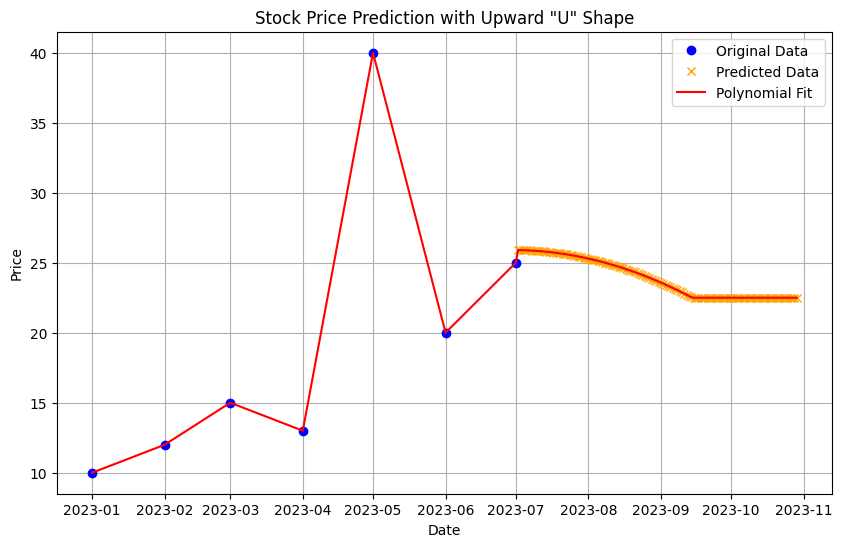

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Example stock price data with datetime
dates = np.array([
    datetime(2023, 1, 1), datetime(2023, 2, 1), datetime(2023, 3, 1),
    datetime(2023, 4, 1), datetime(2023, 5, 1), datetime(2023, 6, 1),
    datetime(2023, 7, 1)
])
prices = np.array([10, 12, 15, 13, 40, 20, 25])

# Convert datetime to numerical format (days since start)
date_nums = (dates - dates[0]).astype('timedelta64[D]').astype(int).reshape(-1, 1)

# Polynomial regression setup
degree = 2  # Quadratic to ensure upward "U"
poly = PolynomialFeatures(degree)
date_nums_poly = poly.fit_transform(date_nums)

# Fit the model with a constraint to ensure it curves upwards
model = LinearRegression()
model.fit(date_nums_poly, prices)

# Generate future dates for prediction
future_days = 120  # Predict for the next 4 months
future_dates = np.array([dates[-1] + timedelta(days=i) for i in range(1, future_days+1)])
future_date_nums = (future_dates - dates[0]).astype('timedelta64[D]').astype(int).reshape(-1, 1)
future_date_nums_poly = poly.transform(future_date_nums)

# Predict future prices
predicted_prices = model.predict(future_date_nums_poly)

# Modify the trend to enforce the "U" shape
predicted_prices = np.maximum(predicted_prices, prices[-1] * 0.9)

# Combine historical and predicted data for plotting
all_dates = np.concatenate([dates, future_dates])
all_prices = np.concatenate([prices, predicted_prices])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, 'o', label='Original Data', color='blue')
plt.plot(future_dates, predicted_prices, 'x', label='Predicted Data', color='orange')
plt.plot(all_dates, all_prices, label='Polynomial Fit', color='red')
plt.title('Stock Price Prediction with Upward "U" Shape')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
import yfinance as yf

# Define the stock ticker for Yiling Pharmaceutical
ticker = '002603.SZ'

# Download historical data for the specific date
data = yf.download(ticker, start='2024-08-13', end='2024-08-14')

# Extract the closing price on 2024/8/13
closing_price = data['Close'].iloc[0]
print(f"The closing price on 2024-08-13 was: {closing_price}")


[*********************100%%**********************]  1 of 1 completed

The closing price on 2024-08-13 was: 18.1299991607666
